# Домашняя работа. Панеш Али 193

### Подготовка

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from itertools import product
import oracles
import optimization as opt
import pandas as pd
import random
import numpy as np
from skdatasets.repositories import libsvm
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

2022-06-23 14:35:56.119709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-23 14:35:56.119777: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Эксперимент: Выбор длины шага в субградиентном методе

### Подготовка и подсчёт

In [3]:
def make_random_dataset(n, m, xscale=1., xmin=0., wscale=1., wmin=0., noise_scale=.1):
    data = np.random.rand(n, m) * xscale + xmin
    w = np.random.rand(m) * wscale + wmin
    return {
        'data': data,
        'target': data @ w + np.random.rand(n) * noise_scale
    }

set_random_seed(107)
experement_config = {
    'random 100 10': make_random_dataset(100, 10),
    'random 100 100': make_random_dataset(100, 100),
}

In [4]:
for _, data in experement_config.items():
    if 'results' in data:
        data.pop('results')
    data['results'] = {
        'x_0': [],
        'x': [],
        'msg': [],
        'alpha_0': [],
        'func': [],
        'time': [],
        'duality_gap': [],
        'best_duality_gap': [],
        'best_func': [],
    }

In [5]:
def store_history(storage, history):
    for name in history:
        if name != 'x':
            storage[name] += [history[name]]


def get_x_0(shape, i, cnt_xs):
    if i == 0:
        return np.zeros(shape)
    if i == 1:
        return np.ones(shape)
    if i < cnt_xs // 2:
        return np.random.rand(shape) - 0.5
    return np.random.rand(shape)


alphas = np.logspace(-8, 2, 16)
cnt_xs = 10

for name, data in experement_config.items():
    oracle = oracles.create_lasso_nonsmooth_oracle(
        data['data'], data['target'], .1)

    for i in range(cnt_xs):
        x_0 = get_x_0(data['data'].shape[1], i, cnt_xs)
        for alpha_0 in alphas:
            x, msg, history = opt.subgradient_method(
                oracle, x_0, alpha_0=alpha_0, trace=True)

            data['results']['x_0'] += [x_0]
            data['results']['x'] += [x]
            data['results']['msg'] += [msg]
            data['results']['alpha_0'] += [alpha_0]
            data['results']['best_duality_gap'] += [oracle.duality_gap(x)]
            data['results']['best_func'] += [oracle.func(x)]
            store_history(data['results'], history)


### Графики

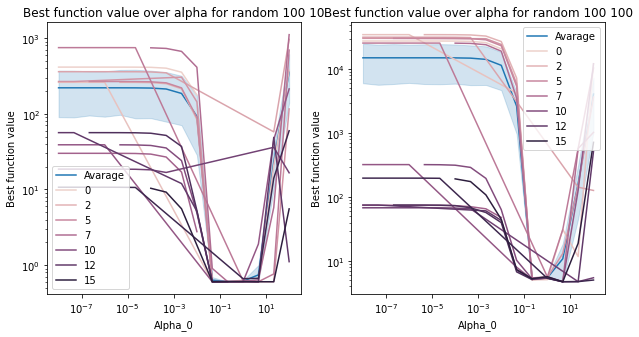

In [6]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))
for ax, (name, data) in zip(axs, experement_config.items()):
    plt.sca(ax)
    sns.lineplot(data['results']['alpha_0'], data['results']['best_func'], label='Avarage')
    sns.lineplot(data['results']['alpha_0'], data['results']['best_func'],
                 hue=np.arange(len(data['results']['alpha_0'])) // cnt_xs)
    plt.yscale('log')
    plt.xscale('log')
    plt.title(f'Best function value over alpha for {name}')
    plt.ylabel('Best function value')
    plt.xlabel('Alpha_0')
clear_output()
plt.show()

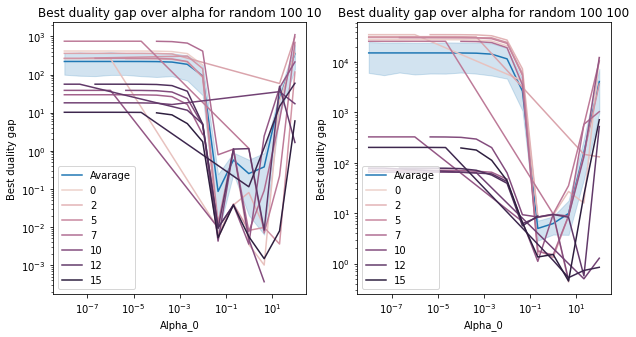

In [7]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))
for ax, (name, data) in zip(axs, experement_config.items()):
    plt.sca(ax)
    sns.lineplot(data['results']['alpha_0'], data['results']['best_duality_gap'], label='Avarage')
    sns.lineplot(data['results']['alpha_0'], data['results']['best_duality_gap'],
                 hue=np.arange(len(data['results']['alpha_0'])) // cnt_xs)
    plt.yscale('log')
    plt.xscale('log')
    plt.title(f'Best duality gap over alpha for {name}')
    plt.ylabel('Best duality gap')
    plt.xlabel('Alpha_0')
clear_output()
plt.show()

### Результаты
- Качество сильно зависит от $alpha_0$
- Качество зависит от $x_0$
- Оптимальное значение $alpha_0$ зависит от $x_0$, но не сильно

## Эксперимент: Среднее число итераций линейного поиска в схеме Нестерова

### Подготовка и подсчёт

In [8]:
for name in experement_config:
    if 'results' in experement_config[name]:
        experement_config[name].pop('results')
    experement_config[name]['results'] = {
        'x_0': [],
        'x': [],
        'msg': [],
        'func': [],
        'time': [],
        'duality_gap': [],
        'best_duality_gap': [],
        'line_iter': [],
        'best_func': [],
    }

In [9]:
set_random_seed(107)
for name, data in experement_config.items():
    oracle = oracles.create_lasso_prox_oracle(
        data['data'], data['target'], 1.)
    x_0 = np.zeros(data['data'].shape[1])
    x, msg, history = opt.proximal_gradient_method(
        oracle, x_0, tolerance=0.3, trace=True, is_storing_iter=True)

    data['results']['x_0'] += [x_0]
    data['results']['x'] += [x]
    data['results']['msg'] += [msg]
    data['results']['best_duality_gap'] += [oracle.duality_gap(x)]
    data['results']['best_func'] += [oracle.func(x)]
    store_history(data['results'], history)

### Графики

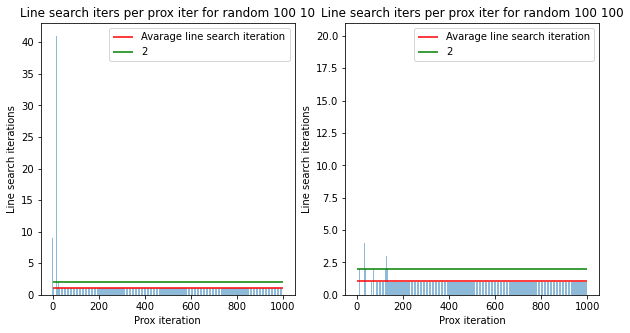

In [10]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))
for ax, (name, data) in zip(axs, experement_config.items()):
    plt.sca(ax)
    plt.bar(np.arange(len(data['results']['line_iter'][0])),
            data['results']['line_iter'][0], alpha=0.5)
    plt.hlines(np.average(data['results']['line_iter'][0]),
               xmin=0, xmax=len(data['results']['line_iter'][0]),
               colors=['r'], label='Avarage line search iteration')
    plt.hlines(2, xmin=0, xmax=len(data['results']['line_iter'][0]), colors=['g'], label='2')
    plt.title(f'Line search iters per prox iter for {name}')
    plt.ylabel('Line search iterations')
    plt.xlabel('Prox iteration')
    plt.legend()
clear_output()
plt.show()

### Результаты
- Да, действительно среднее число итераций около (меньше 2)

## Эксперимент: Сравнение методов

### Подготовка и подсчёт

In [23]:
ns = np.linspace(100, 1000, 10, dtype=int)
ms = np.linspace(10, 100, 10, dtype=int)
lambdas = np.logspace(-4, 2, 10)

In [24]:
def get_method_config(method, oracle, kwargs):
    return {
        'oracle': oracle,
        'method': method,
        'kwargs': kwargs,
    }
    
experement_config = {}
set_random_seed(107)
for n in ns:
    for m in ms:
        experement_config[f'random {n} {m}'] = make_random_dataset(n, m)


methods_config = {
    'subgrad': get_method_config(opt.subgradient_method, oracles.create_lasso_nonsmooth_oracle, {'trace': True}),
    'prox': get_method_config(opt.proximal_gradient_method, oracles.create_lasso_prox_oracle, {'trace': True}),
    'barrier': {'kwargs': {'lasso_duality_gap': oracles.lasso_duality_gap, 'trace': True}},
}

In [20]:
for name in experement_config:
    if 'results' in experement_config[name]:
        experement_config[name].pop('results')

    experement_config[name]['results'] = {}
    for method_name in methods_config:
        experement_config[name]['results'].update({
            method_name: {
                'x_0': [],
                'x': [],
                'msg': [],
                'func': [],
                'time': [],
                'duality_gap': [],
                'best_duality_gap': [],
                'line_iter': [],
                'best_func': [],
                'lambda': [],
            }
        })

In [21]:
for (name, data), (method_name, method_config) in product(experement_config.items(), methods_config.items()):
    for lambd in lambdas:
        x_0 = np.zeros(data['data'].shape[1])
        if method_name == 'barrier':
            x, msg, history = opt.barrier_method_lasso(
                data['data'], data['target'], lambd, x_0,
                np.ones(data['data'].shape[1]), **method_config['kwargs'])
            data['results'][method_name]['best_duality_gap'] += [history['duality_gap'][-1]]
            data['results'][method_name]['best_func'] += [history['func'][-1]]
        else:
            oracle = method_config['oracle'](
                data['data'], data['target'], lambd)
            x, msg, history = method_config['method'](
                oracle, x_0, **method_config['kwargs'])
            data['results'][method_name]['best_duality_gap'] += [oracle.duality_gap(x)]
            data['results'][method_name]['best_func'] += [oracle.func(x)]

        data['results'][method_name]['lambda'] += [lambd]
        data['results'][method_name]['x_0'] += [x_0]
        data['results'][method_name]['x'] += [x]
        data['results'][method_name]['msg'] += [msg]
        store_history(data['results'][method_name], history)
